<a href="https://colab.research.google.com/github/aldyhassan/lilproject/blob/main/critic_movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

#Importing Datasets

In [2]:
# Read data in Google Sheets
sheet_url = 'https://docs.google.com/spreadsheets/d/1U82SNwri5DrSq6Yss0T7Vky8zYOQqOJI6QybqSRdQTA/edit#gid=1933762218'
sheet_url_trf = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

# Open file
df = pd.read_csv(sheet_url_trf)
main_df = df.copy()
main_df.head()

,reviewId,movieId,creationDate,criticName,criticPageUrl,reviewState,isFresh,isRotten,isRtUrl,isTopCritic,publicationUrl,publicationName,reviewUrl,quote,scoreSentiment,originalScore
0,1911099,13a360c0-08ec-316d-afd0-10e6bc016ae5,1800-01-01,Jennie Kermode,/critics/jennie-kermode,fresh,True,False,False,False,/critics/source/1869,Eye for Film,http://www.eyeforfilm.co.uk/reviews.php?id=7588,There have been few song and dance stars in ci...,POSITIVE,4/5
1,1897330,eb6b7381-1511-3c4a-9067-7bbf355a7094,1935-11-08,Scott Nash,/critics/scott-nash,fresh,True,False,False,False,/critics/source/1465,Three Movie Buffs,http://www.threemoviebuffs.com/review/nightatt...,The thing I love about this movie is also the ...,POSITIVE,3/4
2,1897348,716da691-fcea-3594-8dd2-31994f0c926b,1936-01-01,James Berardinelli,/critics/james-berardinelli,rotten,False,True,False,False,/critics/source/387,ReelViews,http://www.reelviews.net/php_review_template.p...,Although some of the production's technical as...,NEGATIVE,2.5/4
3,1911377,f0d7c68d-0619-347c-b4c8-f096af61fa5e,1953-07-15,Scott Nash,/critics/scott-nash,fresh,True,False,False,False,/critics/source/1465,Three Movie Buffs,http://www.threemoviebuffs.com/review/gentleme...,If I had to pick a single movie that best capt...,POSITIVE,3/4
4,1916187,3d883e3d-78b5-37c1-9d79-4ccdfe7ebe46,1957-02-13,NaN,NaN,fresh,True,False,False,False,/critics/source/1697,Bullz-Eye.com,http://www.bullz-eye.com/mguide/reviews_1957/f...,NaN,POSITIVE,4/5


In [3]:
# Dropping Unnecesarry Column
df_drop = df.drop(columns=['movieId', 'criticPageUrl', 'publicationUrl', 'publicationName', 'reviewUrl'])
df_drop.head()

,reviewId,creationDate,criticName,reviewState,isFresh,isRotten,isRtUrl,isTopCritic,quote,scoreSentiment,originalScore
0,1911099,1800-01-01,Jennie Kermode,fresh,True,False,False,False,There have been few song and dance stars in ci...,POSITIVE,4/5
1,1897330,1935-11-08,Scott Nash,fresh,True,False,False,False,The thing I love about this movie is also the ...,POSITIVE,3/4
2,1897348,1936-01-01,James Berardinelli,rotten,False,True,False,False,Although some of the production's technical as...,NEGATIVE,2.5/4
3,1911377,1953-07-15,Scott Nash,fresh,True,False,False,False,If I had to pick a single movie that best capt...,POSITIVE,3/4
4,1916187,1957-02-13,NaN,fresh,True,False,False,False,NaN,POSITIVE,4/5


#Converting creationDate to timeseries

In [4]:
# Change data type to date type (Year-Month-Day Hour-Minutes-Second format)
df_drop['creationDate'] = pd.to_datetime(df_drop['creationDate'], format='%Y-%m-%d')
df_drop['creationDate'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 10719 entries, 0 to 10718
Series name: creationDate
Non-Null Count  Dtype         
--------------  -----         
10719 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 83.9 KB


#Dealing With originalScore issue

In [5]:
# Define function to check for letter grades
def extract_letter_grade(score):
    if pd.isna(score):
        return None
    score_str = str(score).strip()
    letter_grades = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F']
    for grade in letter_grades:
        if score_str == grade:
            return grade
    return None

In [6]:
# Apply function to extract letter grades
df_drop['letterGrade'] = df_drop['originalScore'].apply(extract_letter_grade)
df_drop['letterGrade'].value_counts()

,count
letterGrade,
B+,205
B,192
A,165
A-,164
B-,103
C+,64
C,54
A+,40
C-,19


In [7]:
# Define function to handle different types of scores
def process_score(score):
    if pd.isna(score):
        return None

    # Strip spaces from the string
    score_str = str(score).replace(' ', '').strip()

    # Check for fraction scores (e.g., "4/5", "8/10")
    if '/' in score_str:
        parts = score_str.split('/')
        if len(parts) == 2 and parts[0].replace('.', '', 1).isdigit() and parts[1].replace('.', '', 1).isdigit():
            numerator = float(parts[0])
            denominator = float(parts[1])
            return (numerator / denominator) * 100

    # Check if the score is a number
    if score_str.replace('.', '', 1).isdigit():
        return float(score_str)

    # Otherwise, assume it's a letter grade and return as is
    return score_str

In [8]:
# Apply function to process scores
df_drop['processedScore'] = df_drop['originalScore'].apply(process_score)
df_drop['processedScore'].value_counts()

,count
processedScore,
80.0,1395
100.0,1112
60.0,812
75.0,618
87.5,467
70.0,411
90.0,320
50.0,265
62.5,223


In [9]:
# Define function to convert scores to numeric and map to letter grades
def map_to_letter_grade(score):
    letter_grades = {
        'A+': 100, 'A': 95, 'A-': 90,
        'B+': 85, 'B': 80, 'B-': 75,
        'C+': 70, 'C': 65, 'C-': 60,
        'D+': 55, 'D': 50, 'D-': 45,
        'F': 0
    }

    # Ranges for numeric scores
    grade_ranges = {
        'A+': (97, 100),
        'A': (93, 96),
        'A-': (90, 92),
        'B+': (87, 89),
        'B': (83, 86),
        'B-': (80, 82),
        'C+': (77, 79),
        'C': (73, 76),
        'C-': (70, 72),
        'D+': (67, 69),
        'D': (63, 66),
        'D-': (60, 62),
        'F': (0, 59)
    }

    if pd.isna(score):
        return None

    score_str = str(score).strip()

    # Check for letter grades directly
    if score_str in letter_grades:
        return score_str

    # Check if the score is a number (including decimal)
    if score_str.replace('.', '', 1).isdigit():
        numeric_score = round(float(score_str))
        for grade, (low, high) in grade_ranges.items():
            if low <= numeric_score <= high:
                return grade

    # Return None if no match
    return score

In [10]:
# Apply function to extract or map letter grades
df_drop['letterGrade'] = df_drop['processedScore'].apply(map_to_letter_grade)
df_drop['letterGrade'].value_counts()

,count
letterGrade,
B-,1508
A+,1153
D-,1038
B+,683
C,678
F,594
A-,494
C-,434
B,232


In [11]:
# Finding more unmatch value
unmatch_value = df_drop[df_drop['letterGrade'] == df['originalScore']]['originalScore'].unique()
print(unmatch_value)

['C' 'B-' 'B' 'A' 'B+' 'A+' 'A-' 'C+' 'D+' 'C-' 'D' "2.5/4'" '**1/2' '***'
 'Recommended' 'C-plus' '3.5.5' 'A-minus' 'D-' 'F' 'C=']


In [12]:
# Dictionary for manual corrections
manual_corrections = {
    'BigScreenWatch': None,
    'C-plus': 'C+',
    'NotRecommended': None,
    'ZEROSTARS': '0',
    '3.5.5': '3.5/5',
    'A-minus': 'A-',
    'Recommended': None,
    '3of5': '3/5',
    'Aminus': 'A-',
    '4of5': '4/5',
    '***': None,
    'Bminus': 'B-',
    '105.0': '100.0',
    '**1/2': '0.5/1',
    "2.5/4'": '2.5/4',
    'high+2outof-4..+4': '2.5/4',
    'C=': 'C-'
}

df_drop['letterGrade'] = df_drop['letterGrade'].astype(str).replace(manual_corrections)
df_drop['fixedScore'] = df_drop['letterGrade'].apply(map_to_letter_grade)
df_drop['fixedScore'].value_counts()

,count
fixedScore,
None,3591
B-,1509
A+,1154
D-,1038
B+,683
C,678
F,595
A-,496
C-,435


In [13]:
df_drop['fixedScore'] = df_drop['fixedScore'].apply(process_score)
df_drop['fixedScore'].value_counts()


,count
fixedScore,
None,3591
B-,1509
A+,1154
D-,1038
B+,683
C,678
F,595
A-,496
C-,435


In [14]:
df_drop['fixedScore'] = df_drop['fixedScore'].apply(map_to_letter_grade)
df_drop['fixedScore'].value_counts()

,count
fixedScore,
None,3591
B-,1510
A+,1154
D-,1041
B+,683
C,678
F,596
A-,496
C-,436


In [15]:
df_fix = df_drop.copy()
df_fix = df_fix.drop(columns=['isFresh', 'isRotten', 'isRtUrl', 'quote', 'processedScore', 'letterGrade'])
df_fix.head()

,reviewId,creationDate,criticName,reviewState,isTopCritic,scoreSentiment,originalScore,fixedScore
0,1911099,1800-01-01,Jennie Kermode,fresh,False,POSITIVE,4/5,B-
1,1897330,1935-11-08,Scott Nash,fresh,False,POSITIVE,3/4,C
2,1897348,1936-01-01,James Berardinelli,rotten,False,NEGATIVE,2.5/4,D-
3,1911377,1953-07-15,Scott Nash,fresh,False,POSITIVE,3/4,C
4,1916187,1957-02-13,NaN,fresh,False,POSITIVE,4/5,B-


# EDA

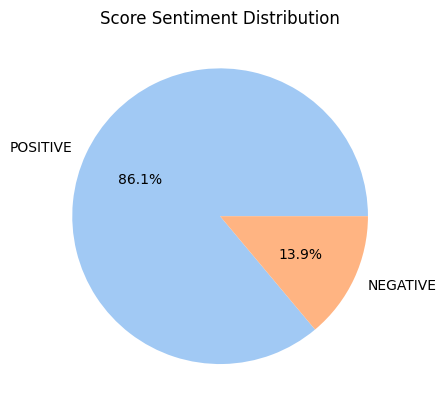

In [ ]:
# Score sentiment pie chart
df_fix['scoreSentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Score Sentiment Distribution')
plt.ylabel('')
plt.show()

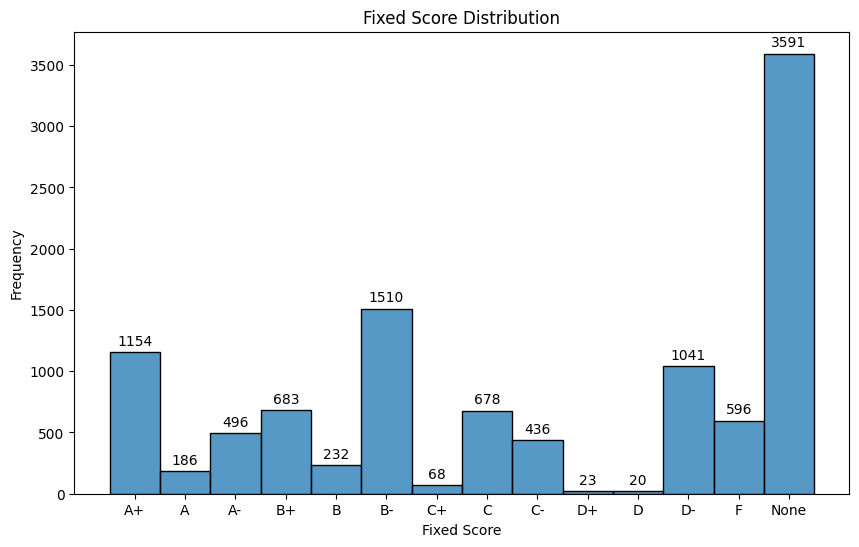

In [19]:
# Fixed score distribution

# Define the ordered categories
ordered_scores = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'None']

# Convert fixedScore to a categorical type with the specified order
df_fix['fixedScore'] = pd.Categorical(df_fix['fixedScore'], categories=ordered_scores, ordered=True)

# Create the histogram
plt.figure(figsize=(10, 6))
ax = sns.histplot(df_fix['fixedScore'], bins= 10, kde=False)
plt.title('Fixed Score Distribution')
plt.xlabel('Fixed Score')
plt.ylabel('Frequency')

# Add frequency labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

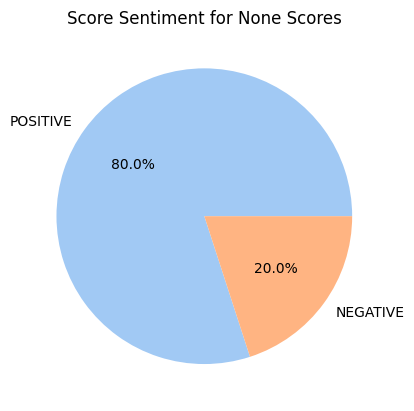

In [ ]:
# None type score with scoreSentiment
none_scores = df_fix[df_fix['fixedScore'].isna()]['scoreSentiment'].value_counts()
none_scores.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Score Sentiment for None Scores')
plt.ylabel('')
plt.show()

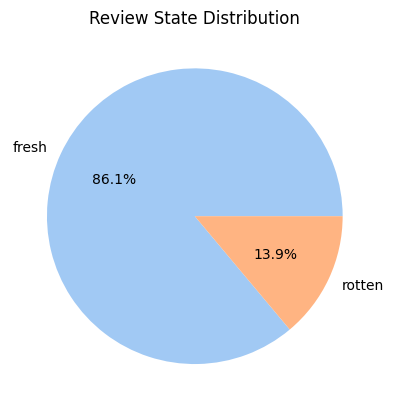

In [ ]:
# Review state pie chart
df_fix['reviewState'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Review State Distribution')
plt.ylabel('')
plt.show()

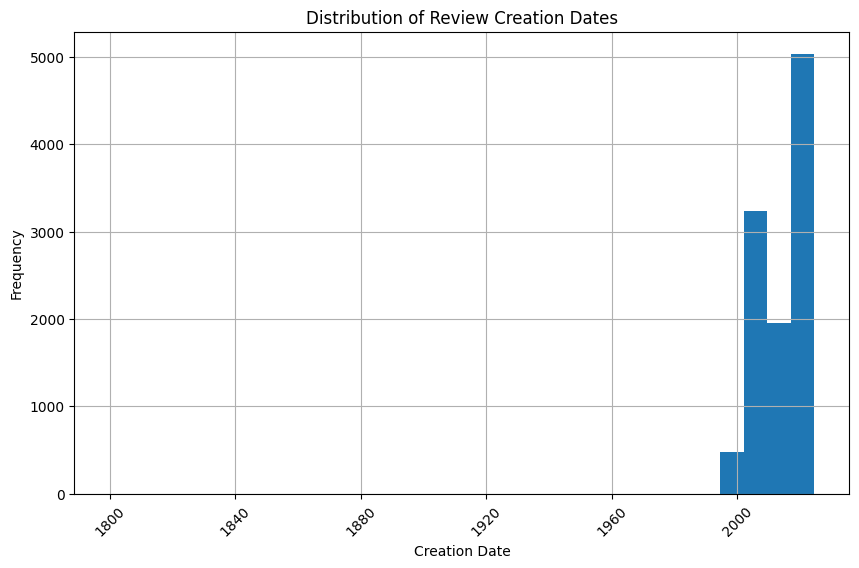

In [ ]:
# Range of creationDate
plt.figure(figsize=(10, 6))
df_fix['creationDate'].hist(bins=30)
plt.title('Distribution of Review Creation Dates')
plt.xlabel('Creation Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
min_date = df_fix['creationDate'].min()
max_date = df_fix['creationDate'].max()
print(f"The reviews range from {min_date} to {max_date}.")

The reviews range from 1800-01-01 00:00:00 to 2024-07-09 00:00:00.


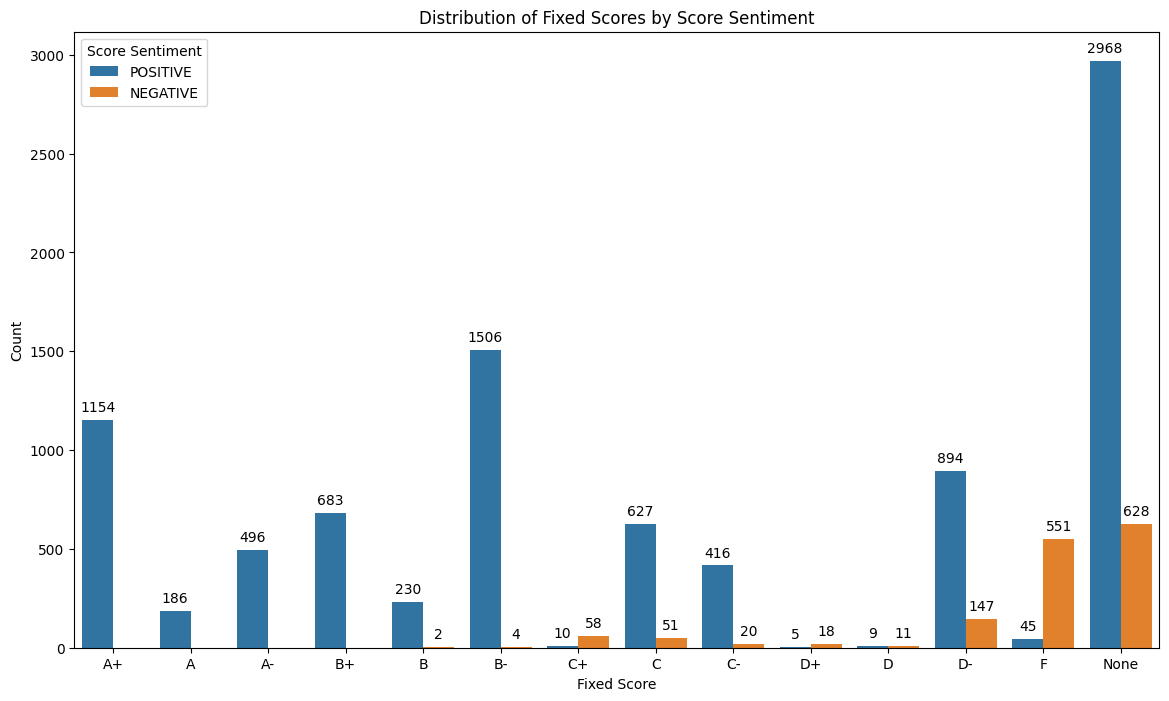

In [26]:
# Distribution between scoreSentiment (positive and negative) and fixedScore

# Replace NaN values in 'fixedScore' with 'None'
df_fix['fixedScore'] = df_fix['fixedScore'].astype(str).replace('nan', 'None')

# Define the ordered categories
ordered_scores = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'None']

# Convert fixedScore to a categorical type with the specified order
df_fix['fixedScore'] = pd.Categorical(df_fix['fixedScore'], categories=ordered_scores, ordered=True)

plt.figure(figsize=(14, 8))
ax = sns.countplot(data=df_fix, x='fixedScore', hue='scoreSentiment', order=ordered_scores)
plt.title('Distribution of Fixed Scores by Score Sentiment')
plt.xlabel('Fixed Score')
plt.ylabel('Count')
plt.legend(title='Score Sentiment')

# Add counts on top of the bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.show()
